In [136]:
# !pip install SimpleITK

In [149]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

image_fixed = nib.load('../images/FLAIR.nii.gz').get_fdata()
image_moving = nib.load('../images/T1.nii.gz').get_fdata()

Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)


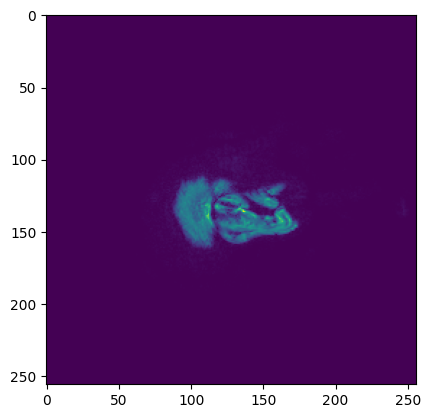

In [150]:
plt.imshow(image_moving[:,:,20])
print("Fixed image : ", image_fixed.shape)
print("Moving image : ", image_moving.shape)

In [139]:
def rigid_registration(image_fixed, image_moving):
    # Convertir las matrices tridimensionales en imágenes SimpleITK
    sitk_fixed = sitk.GetImageFromArray(image_fixed)
    sitk_moving = sitk.GetImageFromArray(image_moving)

    # Crear un transformador de registro rígido
    registration_method = sitk.ImageRegistrationMethod()

    # Definir el tipo de registro y sus parámetros
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0, minStep=1e-4, numberOfIterations=100)
    registration_method.SetInitialTransform(sitk.TranslationTransform(sitk_moving.GetDimension()))

    # Realizar el registro
    transform = registration_method.Execute(sitk_fixed, sitk_moving)

    # Aplicar la transformación al volumen móvil
    registered_image = sitk.Resample(sitk_moving, sitk_fixed, transform, sitk.sitkLinear, 0.0, sitk_moving.GetPixelID())

    # Convertir la imagen SimpleITK resultante en una matriz tridimensional
    registered_array = sitk.GetArrayFromImage(registered_image)

    return registered_array

# Ejemplo de uso:
# Supongamos que tenemos las imágenes image_fixed y image_moving como matrices tridimensionales

In [140]:
rigid_registered_array = rigid_registration(image_fixed, image_moving)

Text(0.5, 1.0, 'Fixed Image')

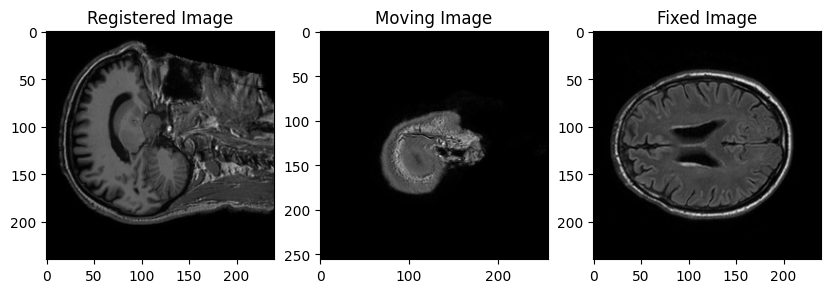

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(rigid_registered_array[:, :, 26], cmap='gray')
ax1.set_title('Registered Image')
ax2.imshow(image_moving[:, :, 26], cmap='gray')
ax2.set_title('Moving Image')
ax3.imshow(image_fixed[:, :, 26], cmap='gray')
ax3.set_title('Fixed Image')

In [152]:
print("Fixed image : ", image_fixed.shape)
print("Moving image : ", image_moving.shape)
print("Registered image : ", rigid_registered_array.shape)


Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)
Registered image :  (240, 240, 48)


In [142]:
def nonrigid_registration(image_fixed, image_moving):
    # Convertir las matrices tridimensionales en imágenes SimpleITK
    sitk_fixed = sitk.GetImageFromArray(image_fixed.astype(np.float32))
    sitk_moving = sitk.GetImageFromArray(image_moving.astype(np.float32))

    # Crear transformada de registro no rígido
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)

    # Establecer el muestreo de la métrica
    registration_method.SetMetricSamplingStrategy(sitk.ImageRegistrationMethod.REGULAR)
    registration_method.SetMetricSamplingPercentage(0.05)

    # Definir los componentes de la transformación
    initial_transform = sitk.TranslationTransform(sitk_fixed.GetDimension())
    bspline_transform = sitk.BSplineTransformInitializer(sitk_fixed, order=3)
    composite_transform = sitk.CompositeTransform([initial_transform, bspline_transform])

    # Realizar el registro no rígido
    registration_method.SetInitialTransform(composite_transform)
    final_transform = registration_method.Execute(sitk_fixed, sitk_moving)

    # Aplicar la transformación al volumen móvil
    registered_image = sitk.Resample(sitk_moving, sitk_fixed, final_transform, sitk.sitkLinear, 0.0, sitk_moving.GetPixelID())

    # Convertir la imagen SimpleITK resultante en una matriz tridimensional
    registered_array = sitk.GetArrayFromImage(registered_image)

    return registered_array

In [143]:
# no_rigid_registered_array = nonrigid_registration('../images/FLAIR.nii.gz', '../images/FLAIR_V2.nii.gz')
no_rigid_registered_array = nonrigid_registration(image_fixed, image_moving)

Text(0.5, 1.0, 'Fixed Image')

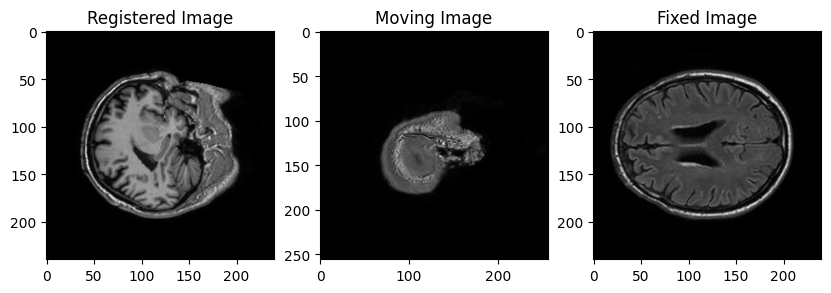

In [144]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(no_rigid_registered_array[:, :, 26], cmap='gray')
ax1.set_title('Registered Image')
ax2.imshow(image_moving[:, :, 26], cmap='gray')
ax2.set_title('Moving Image')
ax3.imshow(image_fixed[:, :, 26], cmap='gray')
ax3.set_title('Fixed Image')

In [151]:
print("Fixed image : ", image_fixed.shape)
print("Moving image : ", image_moving.shape)
print("Registered image : ", image_moving.shape)


Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)
Registered image :  (256, 256, 192)
